<h1>TAREA 4 - Filtrado de Imágenes en el Dominio Espacial</h1>
<h2>Sergio Alejandro Diaz Pinilla</h2>
<h2>Julian Camilo Mendez Corredor</h2>
<br>
<br>
<h2>Punto 1</h2>

<h3>TAREA.</h3>
<li>1. Implementar, en OpenCV, tres de los filtros para reducción de ruido Speckle vistos en clase.</li>
<li>2. Implementar, en OpenCV, cinco de las técnicas de estimación del nivel de ruido vistas en clase.</li>
<li>3. Evaluar el desempeño de los filtros implementados (estimar el nivel de ruido en las imágenes antes y después de filtradas), al ser aplicados sobre imágenes reales y sobre imágenes sintéticas (creadas artificialmente), con diferentes niveles de ruido multiplicativo.</li>

<h1 style="font-size:100%; background-color:rgba(70, 0, 700, 0.2); color:black; text-align:center; line-height : 30px;">
Visión de Máquina &#8212; F. Prieto </h1>


In [2]:
%matplotlib inline
import cv2
import time
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt
from __future__ import division


img = cv2.imread('Fig/face.png',0)
print "Listo"


Listo


(<matplotlib.axes._subplots.AxesSubplot at 0x11927f190>,
 <matplotlib.text.Text at 0x11a7bb6d0>)

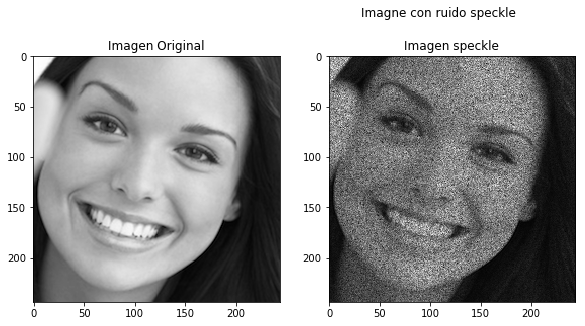

In [44]:
def speckle(img):
    gaussian_noise = np.zeros(img.shape)
    noise = cv2.randn(gaussian_noise,128,30);
    return img*noise

specle_img = speckle(img) 


plt.figure(1,figsize=(15,5))
plt.suptitle('Imagne con ruido speckle')
plt.subplot(131), plt.imshow(img, cmap=plt.cm.gray), plt.title('Imagen Original')
plt.subplot(132), plt.imshow(specle_img, cmap=plt.cm.gray), plt.title('Imagen speckle')


(<matplotlib.axes._subplots.AxesSubplot at 0x12963e550>,
 <matplotlib.text.Text at 0x1293e1c90>)

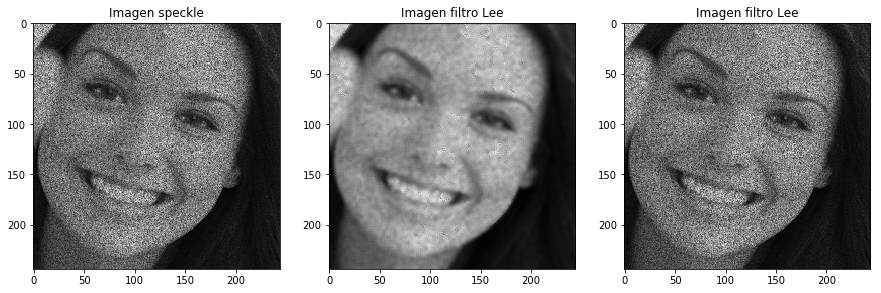

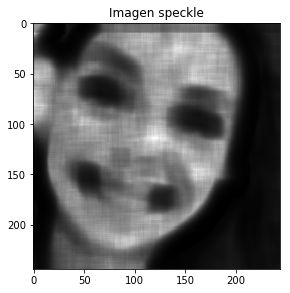

In [89]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance


def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    k = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + k * (img - img_mean)
    return img_output


def kuan_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    L = (img.mean() - img.std())**2
    
    overall_variance = (L*img_variance - img_mean**2) /(L+1)

    up = (img_variance**2) * (img - img_mean)
    down = img_variance**2 + (img_mean + img_variance**2)/L
    
    img_output = img_mean + up/down
    return img_output

def gamma_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    
    L = (img.mean() - img.std())**2
    a = (L+1)/(L*(img_variance/img_mean**2) -1)
    
    const = (a - L - 1)
    
    val = (img_mean**2)*(const**2) + (4*a*L*img*img_mean)
    raiz = np.sqrt(val)
    
    img_output = (a*img_mean + raiz )/ 2*a
    return img_output

plt.figure(1,figsize=(15,5))
plt.subplot(131), plt.imshow(specle_img, cmap=plt.cm.gray), plt.title('Imagen speckle')
plt.subplot(132), plt.imshow(lee_filter(specle_img,5), cmap=plt.cm.gray), plt.title('Imagen filtro Lee')
plt.subplot(133), plt.imshow(kuan_filter(specle_img,10), cmap=plt.cm.gray), plt.title('Imagen filtro Lee')

plt.figure(2,figsize=(15,5))
plt.subplot(131), plt.imshow(gamma_filter(specle_img,20), cmap=plt.cm.gray), plt.title('Imagen speckle')
